# Multi-Armed Bandits

In [12]:
from typing import Optional, Union, List, Dict
import matplotlib.pyplot as plt
import numpy as np

In [13]:
class EpsilonGreedy:

    """
    Initialise epsilon-greedy agent.
    - This agent returns an action between 0 and 'number_of_arms'.
    - It does so with probability `(1-epsilon)` it chooses the action with the highest estimated value, while
    with probability `epsilon`, it samples an action uniformly at random.
    """
    def __init__(self, name: str, number_of_arms: int, epsilon=Union[float, callable]):
        self.name = name
        self._number_of_arms = number_of_arms
        self._epsilon = epsilon
        self.reset()

    """
    Execute Epsilon-Greedy agent's next action and update Epsilon Greedy's action-state values.
    """
    def step(self, previous_action: Optional[int], reward: float) -> int:
        # Execute Epsilon-Greedy
        if previous_action != None:
            # Update action count for previous action
            self.N_t[previous_action] += 1
            # Use iterative form of Q_t(a)
            self.Q_t[previous_action] += (reward - self.Q_t[previous_action]) / self.N_t[previous_action]
        # Check if epsilon is scalar or callable
        new_epsilon = self._epsilon if np.isscalar(self._epsilon) else self._epsilon(self.t)
        # A_t(a) is the 'action' chosen at time step 't'
        action = np.random.choice(np.where(self.Q_t == np.max(self.Q_t))[0]) if np.random.uniform() < 1 - new_epsilon else np.random.randint(0, self.Q_t.shape[0])
        # Update time step counter
        self.t += 1
        # Update true rewards
        self.rewards.append(reward)
        # Update actions
        self.actions.append(action)

    """
    Reset Epsilon Greedy agent.
    """
    def reset(self):
        # Q_t(a) is the estimated value of action ‘a’ at time step ‘t’
        self.Q_t = np.zeros(self._number_of_arms)
        # N_t(a) is the number of times that action ‘a’ has been selected, prior to time ‘t’
        self.N_t = np.zeros(self._number_of_arms)
        # Set time step counter
        self.t = 1
        # Set true rewards
        self.rewards = []
        # Set actions
        self.actions = []

In [14]:
class UCB:
    
    """
    Initialise UCB agent. 
    - This agent returns an action between 0 and 'number_of_arms'.
    - This agent uses uncertainty in the action-value estimates for balancing exploration and exploitation.
    """
    def __init__(self, name: str, number_of_arms: int, bonus_multiplier: float):
        self._number_of_arms = number_of_arms
        self._bonus_multiplier = bonus_multiplier
        self.name = name
        self.reset()

    """
    Execute UCB agent's next action and update UCB's action-state values.
    """
    def step(self, previous_action: Optional[int], reward: Union[float, int]) -> int:
        # Execute UCB
        if previous_action != None:
        # Update action count for previous action
            self.N_t[previous_action] += 1
        # Use iterative form of Q_t(a)
        self.Q_t[previous_action] += (1 / self.N_t[previous_action]) * (reward - self.Q_t[previous_action])
        # All actions must be selected at least once before UCB is applied
        # All actions must be selected at least once before UCB is applied
        if np.any(self.N_t == 0):
            # Select non-explored action
            action = np.random.choice(np.where(self.N_t == 0)[0])
        else:
            # Calculate expected reward values
            reward_values = self.Q_t + self._bonus_multiplier * np.sqrt(np.log(self.t) / self.N_t)
            reward_values[np.isnan(reward_values)] = -np.inf
            # A_t(a) is the 'action' chosen at time step 't'
            action = np.random.choice(np.where(reward_values == np.nanmax(reward_values))[0])
        # Update time step counter
        self.t += 1
        # Update true rewards
        self.rewards.append(reward)
        # Update actions
        self.actions.append(action)

    """
    Reset UCB agent.
    """
    def reset(self):
        # Q_t(a) is the estimated value of action ‘a’ at time step ‘t’
        self.Q_t = np.zeros(self._number_of_arms)
        # N_t(a) is the number of times that action ‘a’ has been selected, prior to time ‘t’
        self.N_t = np.zeros(self._number_of_arms)
        # Set time step counter
        self.t = 1
        # Set true rewards
        self.rewards = []
        # Set actions
        self.actions = []

In [15]:
# Define Greedy Algorithm
greedy_alg = EpsilonGreedy(name="Greedy", 
                           number_of_arms=3, 
                           epsilon=0)
# Define Epsilon-Greedy Algorithm
eps_greedy_alg = EpsilonGreedy(name="Epsilon-Greedy", 
                           number_of_arms=3, 
                           epsilon=0.4)
# Define UCB Algorithm
ucb_alg = UCB(name="UCB", 
              number_of_arms=3, 
              bonus_multiplier=2)

In [20]:
def run_multi_armed_bandits(algs: List, reward_dist: Dict[int, Union[int, float]], start_action: int, num_iter: int):
    # Execute remaining steps of algorithm
    for j in range(num_iter):
        # Loop over each algorithm
        for i in range(len(algs)):
            # Execute first step of algorithm
            if j == 0:
                algs[i].step(previous_action=start_action, reward=reward_dist[start_action])
            else:
                algs[i].step(previous_action=algs[i].actions[j], reward=reward_dist[algs[i].actions[j]])

In [21]:
# Run algorithm
kwargs = {"algs": [greedy_alg, eps_greedy_alg, ucb_alg],
          "reward_dist": {0: np.random.uniform(low=-2, high=2), 1: 5, 2: np.random.normal(loc=10, scale=0.05)},
          "start_action": np.random.randint(0, 3),
          "num_iter": 50}
# NOTE: Since this is in place, the algorithms will get updated dynamically!
run_multi_armed_bandits(**kwargs)

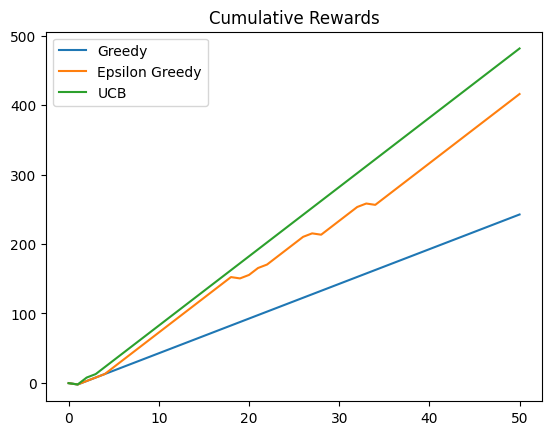

In [22]:
# Plot cumulative rewards
plt.plot(np.cumsum(greedy_alg.rewards), label="Greedy")
plt.plot(np.cumsum(eps_greedy_alg.rewards), label="Epsilon Greedy")
plt.plot(np.cumsum(ucb_alg.rewards), label="UCB")
plt.legend()
plt.title("Cumulative Rewards")
plt.show()

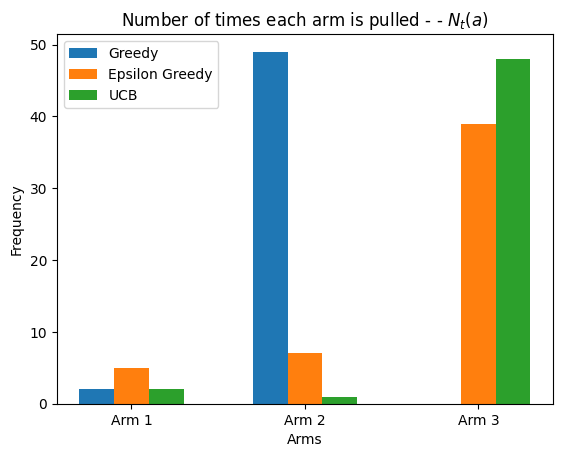

In [31]:
# Plot distribution of pulled arms
categories = ["Arm 1", "Arm 2", "Arm 3"]
bar_width = 0.2 
index = np.arange(len(categories)) 
# Create bar plots for each set of values
plt.bar(index - bar_width, greedy_alg.N_t, bar_width, label='Greedy')
plt.bar(index, eps_greedy_alg.N_t, bar_width, label='Epsilon Greedy')
plt.bar(index + bar_width, ucb_alg.N_t, bar_width, label='UCB')
# Customise the plot
plt.xlabel('Arms')
plt.ylabel('Frequency')
plt.title(r'Number of times each arm is pulled - - $N_{t}\left(a\right)$')
plt.xticks(index, categories)
plt.legend()
plt.show()

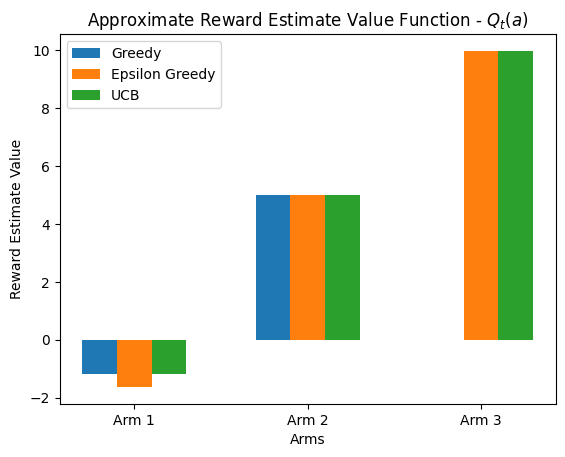

In [30]:
# Plot distribution of pulled arms
categories = ["Arm 1", "Arm 2", "Arm 3"]
bar_width = 0.2 
index = np.arange(len(categories)) 
# Create bar plots for each set of values
plt.bar(index - bar_width, greedy_alg.Q_t, bar_width, label='Greedy')
plt.bar(index, eps_greedy_alg.Q_t, bar_width, label='Epsilon Greedy')
plt.bar(index + bar_width, ucb_alg.Q_t, bar_width, label='UCB')
# Customise the plot
plt.xlabel('Arms')
plt.ylabel('Reward Estimate Value')
plt.title(r'Approximate Reward Estimate Value Function - $Q_{t}\left(a\right)$')
plt.xticks(index, categories)
plt.legend()
plt.show()

# Questions

1. What do you notice about $N_{t}\left(a\right)$ for the respective algorithms? Do any of them perform similarly or differently?
2. What do you notice about $Q_{t}\left(a\right)$ for the respective algorithms? Do any of them perform similarly or differently?
3. What happens if you change the $epsilon$ value in Epsilon-Greedy?
4. What happens if you change the $multiplier$ value in UCB?
5. What happens if you change the iteration length?
6. What happens if you make sure that all arms are pulled, at least once first, and then continue the algorithm? Note that only UCB does this.

# Final Remarks

Thank you for reading this notebook. Note that there are other implementations of recurrent neural networks (which I would advise you to take a look at to see any differences of similarities with this version).
If there are any mistakes or things that need more clarity, feel free to respond and I will be happy to reply 😊.

© *PolyNath 2023*